# Porosity segmentation in X-ray computed CT scans using convolutional neural networks

In this notebook, we will be using convolutional neural networks for the segmentation of pores. Concretely, we'll train a [U-Net](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) architecture. We will train and validate this U-Net on the same pore dataset used in the first practical session.

This notebook contains a mix of questions and programming exercises. The questions and exercises will be indicated in __bold__. Some of these questions are open-ended. They don't necessarily have a right or wrong answer. The idea is that they inspire critical thought and give you some indications on what are the considerations if you ever find yourself designing and testing custom neural networks. We encourage grouping up with one or two other students to discuss these questions. On encountering a question, address it first before moving on in the text/code, otherwise you might spoil the answer!

We will cover some of the harder questions classically during the session.  

# Setting up the environment

In order to do deep learning efficiently, usually a GPU (Graphical Processing Unit) is necessary. Even though deep learning on just a CPU is possible, it is prohibitively slower in all but the most simple cases. Luckily, Google Colab provides us a GPU if we configure the notebook to use one.

To do this, in the above menu, click *Runtime* --> *Change runtime type* --> select *GPU* from the dropdown menu.

If you execute the code below and it prints: *Using device: cuda*, you've done this correctly, if it says *Using device: cpu*, the notebook is running on a cpu.

Some assignments will refer to the line numbers in the code. The default behavior of Google Colab is to not show them. To activate it, use the keyboard shortcut *(Ctrl + M + L)*. If that didn't work, it can also be done in the menu above in: *Tools* --> *settings* -->  *Editor* --> *Show line numbers*

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Execute following code to acces the data:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
# To have access to the data from this notebook
# Go to your google drive -> shared with me 
# Right click on the dataset (dataset_doctoral_schools) -> add shortcut to drive
# Choose the option My Drive

Mounted at /content/gdrive


Let's import all the necessary libraries

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from skimage import io, morphology

Finally, execute the following code, it fixes the random number generator to ensure reproducibility of our results today; It essentially makes sure that (pseudo-)random number generators produce the same sequence of numbers each time you re-execute this entire notebook.

In [5]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataset

In the code below we'll read in our data, which consists of the X-ray CT image slices and their associated label images. We will be loading all this data into the RAM memory. Note that loading all your data is usually not an appropriate approach. In most cases, your dataset will be much too large to fit into your memory, and smaller pieces of data will be fetched ad hoc. Here we decided to load everything in the RAM memory because it is small enough but more importantly, because reading data through Google Colab is very slow. Once our data is completely loaded into the RAM memory, we can acces it much faster. Executing this code may take some time, in the meantime you can already scroll to the next part.

In [6]:
gdrive_path = '/content/gdrive/My Drive/dataset_doctoral_schools/'
labels_file_name = 'labels.tif'
image_subdirectory = 'images/'

image_path = os.path.join(gdrive_path, image_subdirectory)
label_path = os.path.join(gdrive_path, labels_file_name)

# Loading images into RAM memory
images = []
images_list = os.listdir(image_path)
images_list_sorted = sorted(images_list,key=lambda x: int(x.replace('.tif', '').split('_')[1]))
for i, image in enumerate(images_list_sorted):
  images.append(io.imread(os.path.join(image_path, image)))
  print(f'\rReading image {i}/{len(images_list_sorted)-1}', end='')

print('\n')

# Loading labels into RAM memory
#labels = []
#for i in range(0, len(images)):
#  l = io.imread(label_path, img_num=i)
#  labels.append(l.astype(bool))
#  print(f'\rReading label {i}/{len(images)-1}', end='')
labels = io.imread(label_path).astype(bool)
print('Done reading the label file')

Reading image 898/898

Done reading the label file


# U-Net architecture

A [U-Net](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)  network is a convolutional neural network that takes an image as input and computes an ouput image, originally designed for per-pixel segmentation of the input. Its structure is visualized in the image below. The network consists of a contracting path and an expanding path, which gives it its namesake u-shape. The contracting path is a typical convolutional network that consists of repeated application of convolutions, each followed by a rectified linear unit (ReLU) <font color='blue'>[blue arrows]</font> and a max pooling operation <font color='red'>[red arrows]</font>. During the contraction, the spatial information is reduced while feature information is increased. The expanding pathway combines the feature and spatial information through a sequence of up-convolutions <font color='green'>[green arrows]</font> and concatenations with high-resolution features from the contracting path <font color='grey'>[grey arrows]</font>. Note: the dimensions of the individual layers in the figure do not match up with what we will use later on in this notebook. 

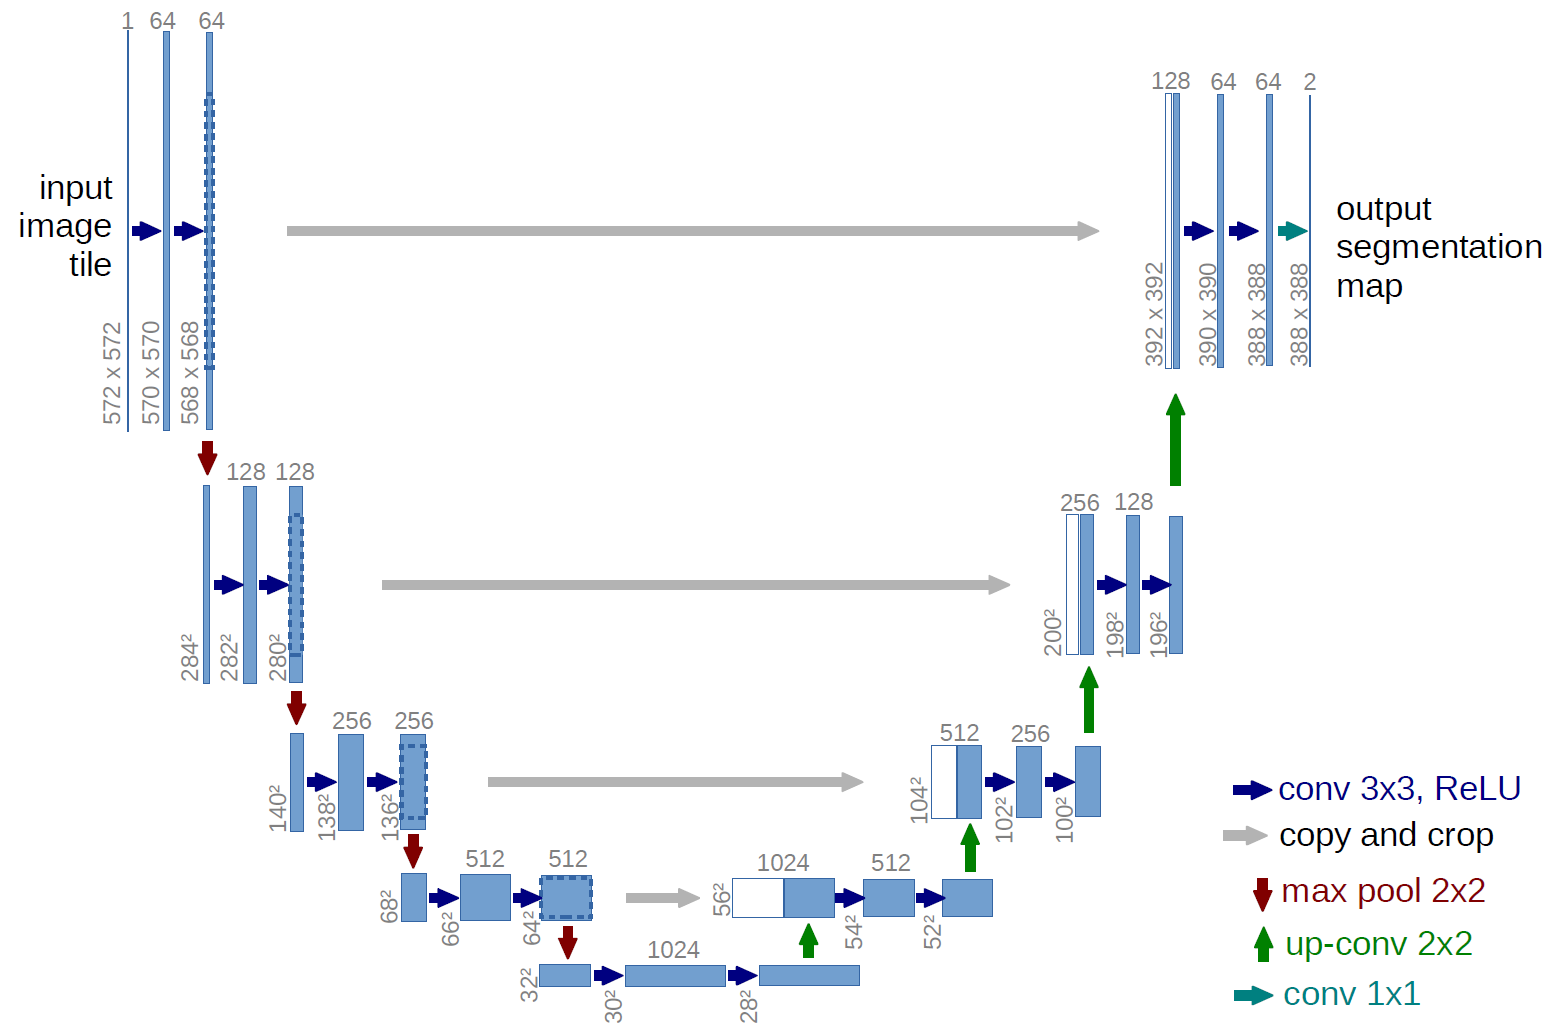

The structure of the network is defined in the code below. In Pytorch the [*Module*](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class is the base class for all neural network modules. That is why all the classes below are inherited from this class. In this so-called object-oriented programming, inheritance is the mechanism of basing a class upon another class, retaining similar implementation. This mechanism provides a means for individual programmers to program their own architectures and networks while being compatible with the powerful training and other code that is prebuilt into the Pytorch framework.
To ensure this compatibility each of these classes needs to implement a *\__init\__()* method, which initializes the module and specifies what kind of layers are present in it. The mandatory *forward()* method specifies how the layers 'connect' in transforming an input into output (this is sometimes called the forward model, hence the name) as well as additional operations that may need to be performed.  

Here we defined three classes:
  1. *ConvNormRelu*: a combination of a convolutional layer, a normalization layer and an activation function.

  2. *ConvBlock*: a combination of two *ConvNormRelu* blocks. 

  3. *Unet*:  the entire U-Net which uses the two other classes (1, 2) to define its structure

<br/><br/>
Take a moment to analyse this code and try to get a rough idea of how it is built up. See if you can link the operations in the figure above to the lines of code below.

__Question__: in the figure above, the final output image has two channels, why?

In [7]:
class ConvNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvNormRelu, self).__init__()
        self.unit = nn.Sequential()
        self.unit.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
        self.unit.add_module('norm', nn.BatchNorm2d(int(out_channels)))
        self.unit.add_module('activation', nn.ReLU())

    def forward(self, inputs):
        return self.unit(inputs)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.unit = nn.Sequential()
        self.unit.add_module('conv1', ConvNormRelu(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
        self.unit.add_module('conv2', ConvNormRelu(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))

    def forward(self, inputs):
        return self.unit(inputs)

class UNet(nn.Module):
    def __init__(self, feature_maps=16, out_channels=2):
        super(UNet, self).__init__()

        self.feature_maps = feature_maps

        # encoder layers
        self.conv_enc_1 = ConvBlock(in_channels=1, out_channels=feature_maps)
        self.conv_enc_2 = ConvBlock(in_channels=feature_maps, out_channels=2*feature_maps)
        self.conv_enc_3 = ConvBlock(in_channels=2*feature_maps, out_channels=4*feature_maps)
        self.conv_enc_4 = ConvBlock(in_channels=4*feature_maps, out_channels=8*feature_maps)
        self.pool = nn.MaxPool2d(2, 2)

        # bottleneck layers
        self.conv_btl = ConvBlock(in_channels=8*feature_maps, out_channels=16*feature_maps)

        # decoder layers
        self.conv_dec_4_up = nn.ConvTranspose2d(in_channels=16*feature_maps, out_channels=8*feature_maps, kernel_size=2, stride=2)
        self.conv_dec_4 = ConvBlock(in_channels=16*feature_maps, out_channels=8*feature_maps)
        self.conv_dec_3_up = nn.ConvTranspose2d(in_channels=8*feature_maps, out_channels=4*feature_maps, kernel_size=2, stride=2)
        self.conv_dec_3 = ConvBlock(in_channels=8*feature_maps, out_channels=4*feature_maps)
        self.conv_dec_2_up = nn.ConvTranspose2d(in_channels=4*feature_maps, out_channels=2*feature_maps, kernel_size=2, stride=2)
        self.conv_dec_2 = ConvBlock(in_channels=4*feature_maps, out_channels=2*feature_maps)
        self.conv_dec_1_up = nn.ConvTranspose2d(in_channels=2*feature_maps, out_channels=feature_maps, kernel_size=2, stride=2)
        self.conv_dec_1 = ConvBlock(in_channels=2*feature_maps, out_channels=feature_maps)

        # final segmentation layer
        self.conv_final = nn.Conv2d(in_channels=feature_maps, out_channels=out_channels, kernel_size=1)

    def forward(self, x):

        # encoder path
        x1 = self.conv_enc_1(x)
        x = self.pool(x1)
        x2 = self.conv_enc_2(x)
        x = self.pool(x2)
        x3 = self.conv_enc_3(x)
        x = self.pool(x3)
        x4 = self.conv_enc_4(x)
        x = self.pool(x4)

        # bottleneck
        x = self.conv_btl(x)

        # decoder path
        x = torch.cat((self.conv_dec_4_up(x), x4), dim=1)
        x = self.conv_dec_4(x)
        x = torch.cat((self.conv_dec_3_up(x), x3), dim=1)
        x = self.conv_dec_3(x)
        x = torch.cat((self.conv_dec_2_up(x), x2), dim=1)
        x = self.conv_dec_2(x)
        x = torch.cat((self.conv_dec_1_up(x), x1), dim=1)
        x = self.conv_dec_1(x)

        # final segmentation
        x = self.conv_final(x)

        return x

# Dataset (continued)

The data should be loaded by now. If that is not the case you may have to wait a bit longer to continue.

As a sanity check, let's visualise a single slice and its associated label image to double check if they match. You can play around with the *s_n* variable to see other slices (as long as it stays in range of the amount of images).

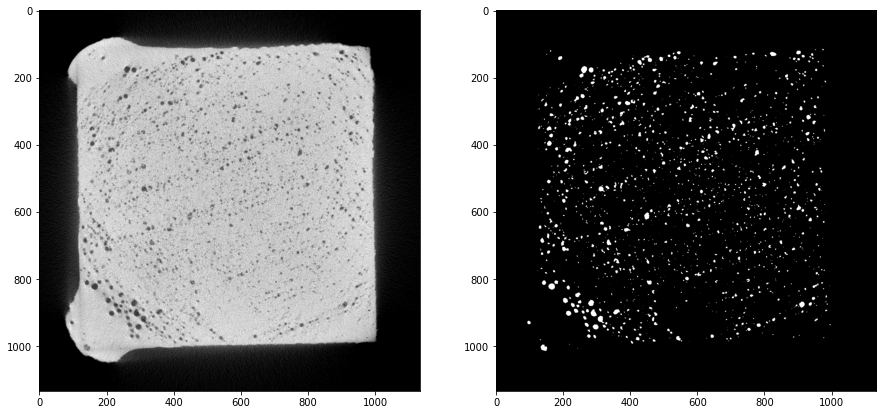

In [8]:
s_n = 800
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 15))
ax[0].imshow(images[s_n], cmap='gray')
ax[1].imshow(labels[s_n], cmap='gray')

__Exercise__: it might be hard to verify this if the images are visualised side by side, can you implement something better? (tip: we've done something similar in the previous practical session)

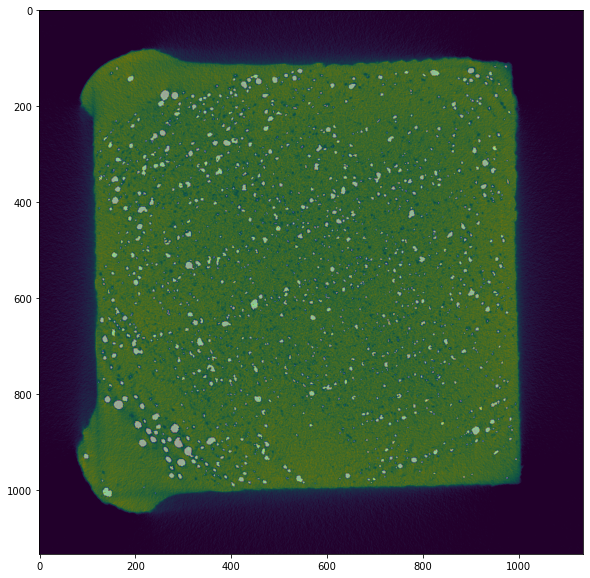

In [9]:
# Add your own implementation of visualization here:

plt.figure(figsize=(10,10))

# FILL IN: try different values for alpha (replace None)
plt.imshow(images[s_n])
plt.imshow(labels[s_n], cmap='inferno', alpha = 0.5)
plt.show()



Pytorch provides us a simple but effective way to work with custom data: the [*Dataset*](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) class. In the code below we defined a *Data* class that inherits from this class. Any class that inherits from the *Dataset* class has to implement three methods:
 1. *\__init\__()*: initializes the object and saves all the relevant parameters and information to fetch the data

 2. *\__getitem\__(idx)*: returns a sample from the dataset at the given index idx

 3. *\__len\__()*: returns the number of samples in our dataset

This class is very useful for using custom data because it essentially gives us all we need from our data in one convenient class:
  1. how is the data defined, where can we find it, custom parameters, etc. (*\__init\__()*)
  2. how should I fetch a single sample of the data? (*\__getitem\__(idx)*)
  3. how much samples are in the dataset? (*\__len\__()*)

Let's analyse the code written below a bit more in detail to understand what is going on. We'll start by looking into the input arguments of the *\__init\__()* method (line 3 of the code):
 - *self*: this is typical Python syntax to define that this is a class method, you don't need to worry about understanding this
 - *images & labels*: this is our data (input & output)
 - *split*: __Questions__: What could this input argument mean (tip: you can deduce this from the code)? Why is it important (recall the theory)?
 - *patch_size*: instead of training our model to work on full images, we will train it on randomly sampled image patches (smaller cut-out pieces), this argument determines the size of the patches. __Questions__: can you list some reasons why we would take this approach? Are there disadvantages to this approach?
 - *max_iter_epoch*: recall from the theory that we train deep learning models for a certain amount of epochs. For every epoch, the model is trained on the entire (training) dataset. Since in our approach we randomly sample patches, there is not really a notion of the *entire dataset*. Indeed, in theory we could randomly sample a very very large number of patches. In practice, we will set an upper bound of how many patches we randomly sample from the dataset for a single epoch. This is chosen by setting this input argument.
<br/><br/>
__Question__: analyse the data splitting code (lines 10 to 16), how large is each split? 

 __Question__: analyse the code and describe broadly what is happening. Do this for line 21, lines 24 & 25 (grouped), lines 29 & 30 (grouped), lines 33 & 34 (grouped) and line 37. (tip: see [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html) of the randint function)



In [10]:
class Data(data.Dataset):

  def __init__(self, images:list, labels:list, split:str, patch_size:tuple, max_iter_epoch:int):

    self.images = images
    self.labels = labels
    self.patch_size = patch_size
    self.max_iter_epoch = max_iter_epoch
    
    if(split == 'train'):
      self.slices = np.arange(0, int(0.6*len(self.images)))
    elif(split == 'validation'):
      self.slices = np.arange(int(0.6*len(self.images)), int(0.8*len(self.images)))
    elif(split == 'test'):
      self.slices = np.arange(int(0.8*len(self.images)), len(self.images))
    else: raise Exception(f'A non valid split was given: \'{split}\'. Please specify train, validation or test.')

  def __getitem__(self, i:int):

    # 
    z = self.slices[np.random.randint(len(self.slices))]

    # 
    img = self.images[z]
    GT = self.labels[z]
    
    # 
    # 
    x = np.random.randint(self.patch_size[0], img.shape[1]-self.patch_size[0]+1) 
    y = np.random.randint(self.patch_size[1], img.shape[1]-self.patch_size[1]+1) 

    # 
    img = img[x-int(patch_size[0]/2):x+int(patch_size[0]/2), y-int(patch_size[1]/2):y+int(patch_size[1]/2)]
    GT = GT[x-int(patch_size[0]/2):x+int(patch_size[0]/2), y-int(patch_size[1]/2):y+int(patch_size[1]/2)]

    # 
    GT = np.array([GT, 1.0-GT])

    # put the data in the correct format for pytorch
    return torch.from_numpy(img).unsqueeze_(0), torch.from_numpy(np.float32(GT))

  def __len__(self):
    return max_iter_epoch

The code above only defines the Data class, in the code below we will actually instantiate the data objects for each split. We will choose a patch size of (128, 128), this means that each randomly selected patch will be an image of size 128x128. The *max_iter_epoch* argument is set to 256, so for each epoch, 256 patches in total are randomly sampled.

In [11]:
patch_size = (128, 128)
max_iter_epoch = 256

data_train = Data(images, labels, 'train', patch_size, max_iter_epoch)
data_validation = Data(images, labels, 'validation', patch_size, max_iter_epoch)
data_test = Data(images, labels, 'test', patch_size, max_iter_epoch)

# Training Procedure

So far we have defined the structure of our deep learning model, and defined and created our data objects. Our next goal is to actually train our model. A procedure was written below to do just that. Look at the input arguments of the method, think about why all of them are important.

__Question__: why is the testing data not needed in this procedure? 
<br/><br/>

In lines 4 to 19 in the code we prepare the data, the model, the optimizer and the loss function. We use [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (line 19 in the code) as loss function and the [Adam algorithm](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as optimizer (line 12). The actual training loop starts from line 28. 
<br/><br/>

__Question__: within every epoch, we iterate over the batches in the for loop from line 33 to 49. Analyse the code and explain what is happening in this loop (lines 39 to 47).

__Question__: what is the code doing between lines 53 to 63 and between lines 67 to 76. Why is it important to keep track of this?

In [12]:
def train_model(model, data_train, data_validation, batch_size:int, learning_rate:float, n_epochs:int):

  # initialize the dataloaders
  dataloader_train = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True, num_workers=2)
  dataloader_validation = DataLoader(dataset=data_validation, batch_size=batch_size, shuffle=True, num_workers=2)

  # check which device we are running on
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f'Using device: {device}')

  # initialize the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # load the model to device
  model = model.to(device)

  # define the loss
  #class_weights = torch.from_numpy(np.array([2, 1])).float().to(device)
  loss_fn = nn.CrossEntropyLoss()

  n_total_steps_train = len(dataloader_train)

  #define some lists to safe training information
  training_losses = []
  validation_losses = []

  ###########          training loop          ###############
  for epoch in range(n_epochs):    

      model.train(True)

      # iterate over batches
      for i, (images, groundtruths) in enumerate(dataloader_train):

          images = images.to(device)
          groundtruths = groundtruths.to(device)

          # 
          results = model(images)
          loss = loss_fn(results, groundtruths)
                                                        
          # 
          optimizer.zero_grad()
          loss.backward()

          # 
          optimizer.step()

          print(f'\repoch {epoch+1} / {n_epochs}, step {i+1}/{n_total_steps_train}, training_loss = {"-"}, validation_loss = {"-"}', end='')


      # 
      model.train(False)
      train_loss = 0
      with torch.no_grad():

          for (images, groundtruths) in dataloader_train:
              out = model(images.to(device))
              loss = loss_fn(out, groundtruths.to(device))
              train_loss += loss.cpu().numpy()

          train_loss /= len(dataloader_train)
          training_losses.append(train_loss)


      # 
      val_loss = 0
      with torch.no_grad():

        for (images, groundtruths) in dataloader_validation:
          out = model(images.to(device))
          loss = loss_fn(out, groundtruths.to(device))
          val_loss += loss.cpu().numpy()

        val_loss /= len(dataloader_validation)
        validation_losses.append(val_loss)

                    
      print(f'\repoch {epoch+1} / {n_epochs}, step {i+1}/{n_total_steps_train}, training_loss = {train_loss:.7f}, validation_loss = {val_loss:.7f}\n')

  return training_losses, validation_losses

# Training

Everything is now in place to start training! Let's start using the hyperparameters given in the code below. After the training is finished, we will plot the learning curves. Note: executing this code will take some time. In the meantime, think about these questions:
<br/><br/>

__Question__: Which loss value gives a more representative idea of how well the model would perform on unseen data: the loss on the training set or the loss on the validation set?

__Question__: What would an ideal learning curve look like (validation and training loss curve)?

__Question__: Suppose there is a large difference between the training loss value and validation loss value. What could be causing this? (Note: this is a hypothetical question, it might not apply to this particular learning curve)

__Question__: Suppose the training loss decreases but the validation loss increases. How could this be explained? (Note: this is a hypothetical question, it might not apply to this learning curve)

Using device: cuda
epoch 1 / 20, step 32/32, training_loss = 0.3106396, validation_loss = 0.2881881

epoch 2 / 20, step 32/32, training_loss = 0.2287615, validation_loss = 0.2370314

epoch 3 / 20, step 32/32, training_loss = 0.1307324, validation_loss = 0.1288755

epoch 4 / 20, step 32/32, training_loss = 0.0858702, validation_loss = 0.0881358

epoch 5 / 20, step 32/32, training_loss = 0.0538190, validation_loss = 0.0500437

epoch 6 / 20, step 32/32, training_loss = 0.0447429, validation_loss = 0.0434581

epoch 7 / 20, step 32/32, training_loss = 0.0320231, validation_loss = 0.0303004

epoch 8 / 20, step 32/32, training_loss = 0.0250043, validation_loss = 0.0241594

epoch 9 / 20, step 32/32, training_loss = 0.0219192, validation_loss = 0.0216860

epoch 10 / 20, step 32/32, training_loss = 0.0176586, validation_loss = 0.0177710

epoch 11 / 20, step 32/32, training_loss = 0.0154509, validation_loss = 0.0153657

epoch 12 / 20, step 32/32, training_loss = 0.0124493, validation_loss = 0.012

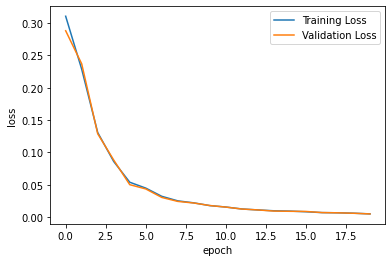

In [13]:
batch_size = 8
learning_rate = 1e-3
n_epochs = 20

model = UNet(feature_maps=16)

t_losses, v_losses = train_model(model, data_train, data_validation, batch_size, learning_rate, n_epochs)

plt.figure()
plt.plot(t_losses, label='Training Loss')
plt.plot(v_losses, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

Take some time to analyse the training curves. __Questions__: is this what you expected? Is this a good learning curve? 

# Model output

It is important inspect the output of the model to understand exactly what kind of information it is giving us. A good way to do this is to generate a random patch, feed it as input to our trained neural network and look at the output image.

__Question__: Can you predict the shape of the output array?

In [14]:
  model.train(False)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  with torch.no_grad():
    # generate random patch
    r = np.float32(np.random.rand(patch_size[0],patch_size[1]))
    # make it into a tensor with the right shape
    r = torch.from_numpy(r).unsqueeze_(0).unsqueeze_(0)
    # push it through
    out_tensor = model(r.to(device))
    # get it back into a numpy array 
    out_numpy = np.squeeze(out_tensor.cpu().numpy())

# print out the shape
print(f'shape of the array: {out_numpy.shape}')

shape of the array: (2, 128, 128)


Let's first inspect the values that our network outputs. We will print out the output values of the pixel at position (0,0).

In [15]:
values = out_numpy[:, 0,0]
print(values)

[-2.615246  2.962631]


__Question__: what do these values represent?

<br/><br/>
<br/><br/>

In context of neural networks, a logit is the "raw" prediction of the last layer of the network. Its values correlate to some output the neural network is trying to predict.

These values are usually hard to interpret and require some kind of normalization to make sense of them.

The method in the code below is a very popular to make these values more interpretable. 

__Question__: what exactly are we doing to the values in the code below? (tip: see [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html))

__Question__: how could we interpret these values now? 

__Question__: what would be the prediction of the model be here: is this pixel a pore pixel or not?

In [16]:
t = torch.nn.Softmax(dim=0)
print(t(torch.from_numpy(values)))

tensor([0.0038, 0.9962])


__Question__: Let's say that (for convenience) instead of outputting two values for each pixel, and thus having two channels in the output, we want one channel. Where the single channel just indicates in a binary matter if a pixel is a pore (logical 1) or not (logical 0). What kind of operation could we apply to the original output. (tip: we essentially want to map two channels into one using some operation, see figure below). No need to devise some mathematical operation here, just think about it conceptually.


Important note: what a model outputs is entirely dependent on how the programmer has defined its model. In our implementation, the last layer is just a convolutional layer with nothing attached to it in the end, so we end up with logits as output. Some programmers prefer to work with a normalization layer already defined in the model, some don't. Sometimes it is necessary to end with the logits because a pytorch loss function requires it so (as it is in our case), other times not. So be aware that it is something you have to look out for.

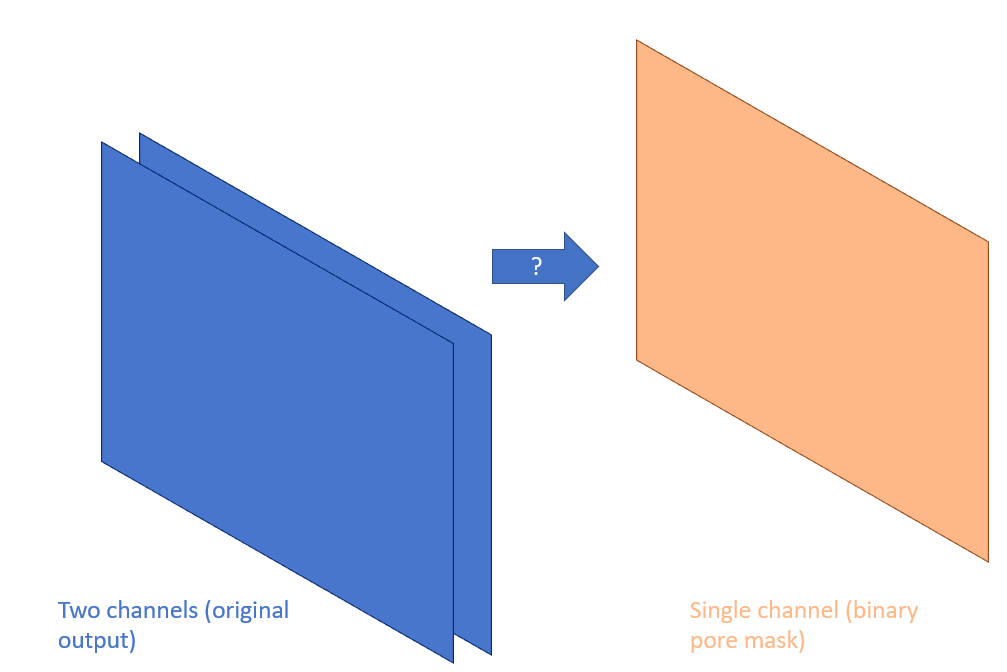

# Testing Procedure

After training a model, the next step is to evaluate it. We should do this on testing data, data that wasn't used for the purpose of training. Different evaluation metrics may be computed and conclusions drawn from their interpretation. Additionally, image processing has the advantage of allowing visual inspection of output. This allows to quickly find out if the model is producing anything meaningful. So we'll start with that. In the code below we pick one slice from the test data which we'll use to analyse the output of the model.

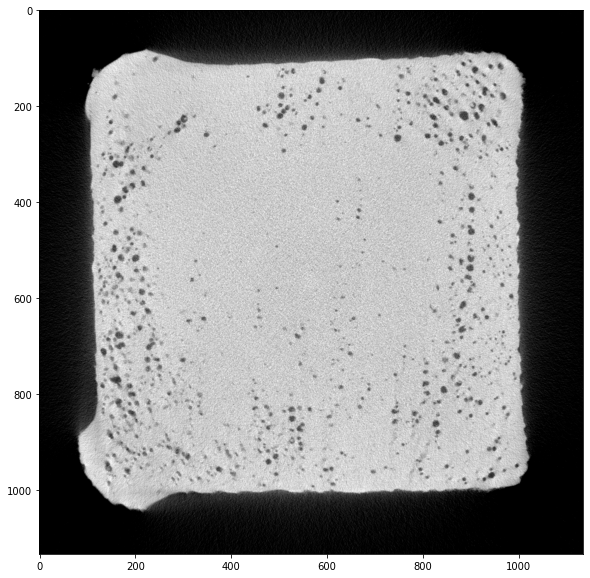

In [17]:
img = data_test.images[data_test.slices[50]]
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

A problem arises: Since we trained our model on smaller patches, so we can not simply input our entire image into the model to get our label image. This is solved by cutting our entire image into patches of the size we need, and feeding them one by one as input for the model to get the labels for each patch. Then, we recombine (stitch) together the label image of each patch to obtain a complete label image. The code below does just that.

__Question__: in lines 31 and 32 of the code we fetch the output from the model, however, we do not use it as the final segmentation output of a single patch, instead we first execute the code in line 33. The *seg* variable is then used as the segmentation output of a single patch. What is this step for? (tip: this relates to the previous question. Documentations on the [*argmax*](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function) 

In [18]:
def segment_slice(model, image, patch_size:tuple):
  # first we will split up our image in patches
  patches = []
  
  # figure out how many patches fit in both axes
  x_n = image.shape[0]/patch_size[0]
  y_n = image.shape[1]/patch_size[1]

  # if this is not an integer, we will have to add some pixels to the image
  if(not x_n.is_integer() or not y_n.is_integer()):
    patch_add_x = int(patch_size[0] - (image.shape[0] - np.floor(x_n)*patch_size[0]))
    patch_add_y = int(patch_size[1] - (image.shape[0] - np.floor(y_n)*patch_size[1]))
    img_p = np.zeros((image.shape[0]+patch_add_x, image.shape[1]+patch_add_y), dtype=np.float32)
    img_p[0:image.shape[0], 0:image.shape[1]] = image
  else:
    img_p = image

  # create all the patches and add them to a list
  for x in range(0, int(np.ceil(x_n))):
    for y in range(0, int(np.ceil(y_n))):
      patch = img_p[x*patch_size[0]:(x+1)*patch_size[0], y*patch_size[1]:(y+1)*patch_size[1]]
      patches.append(patch)

  # push the patches through the model to get an segmented output for each patch, add it to a list
  labels_patches = []
  model.train(False)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  with torch.no_grad():
    for patch in patches:
      patch = torch.from_numpy(patch).unsqueeze_(0).unsqueeze_(0)
      out = model(patch.to(device))
      out = out.cpu().numpy()
      seg = np.argmax(out[0], axis=0)
      labels_patches.append(seg)
  
  # reorganize the list into a grid for easier recombination
  labels_patches = np.reshape(labels_patches, (int(np.ceil(x_n)), int(np.ceil(y_n)), patch_size[0], patch_size[1]))

  # recombine the patches into a label image
  label_image = np.zeros(img_p.shape, dtype=np.uint8)
  for x in range(0, int(np.ceil(x_n))):
    for y in range(0, int(np.ceil(y_n))):
      label_image[x*patch_size[0]:(x+1)*patch_size[0], y*patch_size[1]:(y+1)*patch_size[1]] = labels_patches[x,y]

  # We can't forget the remove the pixels we added in case patches didn't fit the image
  if(not x_n.is_integer() or not y_n.is_integer()):
    label_image_final = np.zeros(image.shape, dtype=np.uint8)
    label_image_final = label_image[0:label_image.shape[0]-patch_add_x, 0:label_image.shape[1]-patch_add_y]
  else:
    label_image_final = label_image

  # in the output of the model, class 0 are the pore pixels, so in order to get an image where 1 is represented as a pore pixel, we have to invert
  return 1-label_image_final

Above is just the code for this procedure, the following code actually executes the procedure and visualises the end result:

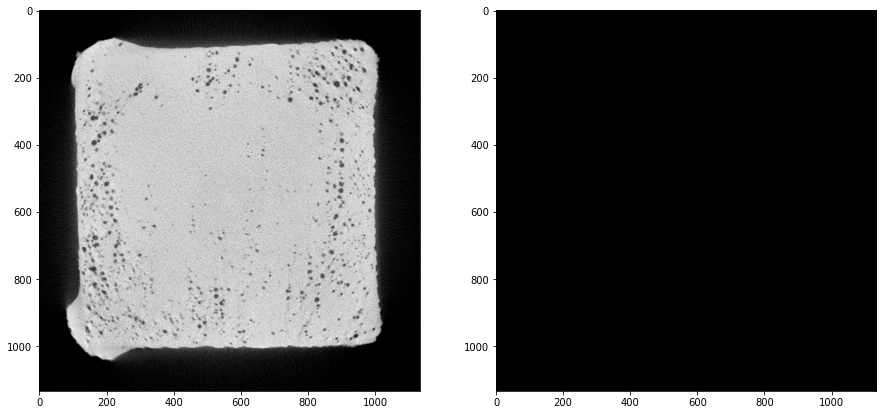

In [19]:
label_image = segment_slice(model, img, patch_size)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 15))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(label_image, cmap='gray')

Woops, seems like the model did not output anything meaningful. 

__Question__: Can you hypothesize a reason for the model not learning anything meaningful? 

__Question__: What could be a next step in finding out what the problem might be?

<br/><br/>
<br/><br/>

Data exploration! That's what we've been missing. In our dataset definition we mindlessly split the data up into the training, validation and test sets. Instead, we should have inspected these sets before proceeding with them.

__Question__: what characteristics would an ideal training set, validation set and test set have?

Let's consider the distribution of the pores throughout the sample in our data. For this we iterate over every slice label image, and count how many pixels of each slice is a pore pixel. We then plot it out this *pore pixel count* as a function of the slice number, as seen below.

Text(0, 0.5, 'Pore pixel count')

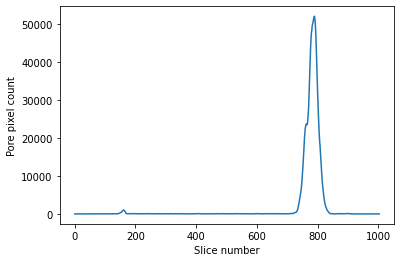

In [20]:
hist = []
for i in range(0, len(labels)):
  hist.append(np.count_nonzero(labels[i]))

plt.plot(np.arange(0, len(hist)), hist)
plt.xlabel('Slice number')
plt.ylabel('Pore pixel count')

__Question__: looking at this distribution, can you now hypothesize why the model did not learn anything meaningful? 

Just to confirm your hypothesis, let's visually inspect a few patches from the training set below, with the images on the left showing the original image and the one the right showing the ground truth.

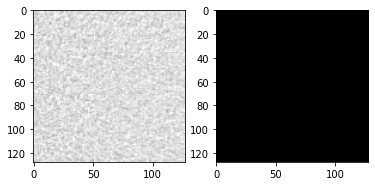

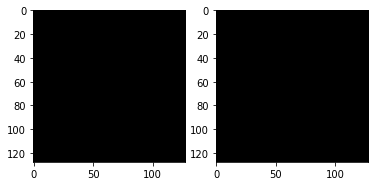

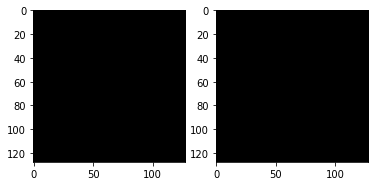

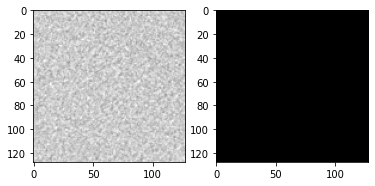

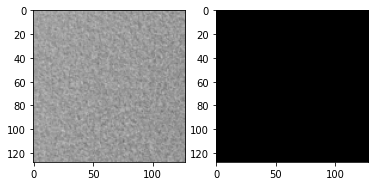

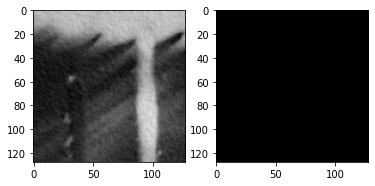

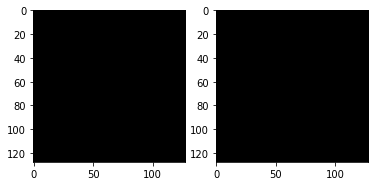

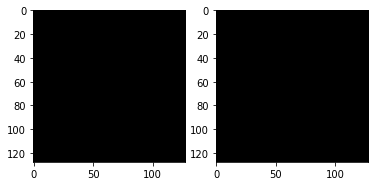

In [21]:
dataloader_train = DataLoader(dataset=data_train, batch_size=8, shuffle=True, num_workers=2)
iterator = iter(dataloader_train)
imgs, GT = next(iterator)

for im, gt in zip(imgs, GT):
  fig, ax = plt.subplots(nrows = 1, ncols = 2)
  ax[0].imshow(im[0, :, :], cmap='gray', vmin=0, vmax=1)
  ax[1].imshow(gt[0, :, :], cmap='gray', vmin=0, vmax=1)

del imgs, GT

__Question__: is this what you expected? Does it confirm your hypothesis?

__Question__: how can we fix this?

<br/><br/>
<br/><br/>

# Dataset (Version 2)

At this point we have established that our model is not learning anything useful because we performed an inappropriate data split into training/validation data set. Thus the solution is to choose a better-considered data split. First of all, let's remove all slices without any porosity as it is silly to expect a neural network to learn about porosity features when there is no porosity in the data. We find that this is the range outside of [700, 850]. 

For the remaining slices, these are the ones with porosity, we will aim for a 60%/20%/20% train/validation/test split. There are still different ways to define this. The most obvious way is to apply the 60/20/20 ratios to select slices. Alternatively, we can apply the 60/20/20 ratios to the total amount of pore pixels. That way 60% of the pore pixels (not necessarily 60% of the slices) will be in the training set, 20% in the validation and 20% in the test split. 

__Question__: Are there any advantages or disadvantages to making the split according to the total amount of pore pixels instead of slice fractions?

__Question__: how could we find good slice ranges to approximate that 60%/20%/20% split?


<br/><br/>
<br/><br/>


To practically identify slice ranges that correspond to the 60/20/20 ratios in terms of pore pixel fraction, we will first build a so-called normalized cumulative distribution. Below is some code to calculate this, plot it, and find slice values that approximate this split choice.

__Question__: can you figure out what the code is doing in lines 3 and 4?


upper bound slice for training set: 788
upper bound slice for vaidation set: 797



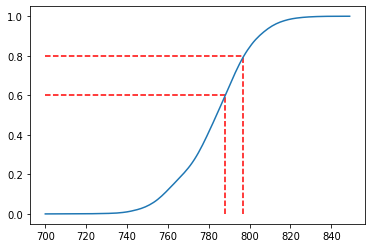

In [22]:
cumulative = np.cumsum(hist[700:850])/np.sum(hist[700:850])

t_slice = np.argmin(np.abs(cumulative-0.6))
v_slice = np.argmin(np.abs(cumulative-0.8))

print(f'upper bound slice for training set: {t_slice+700}')
print(f'upper bound slice for vaidation set: {v_slice+700}\n')

plt.plot(np.arange(700,850,1), cumulative)
plt.vlines(t_slice+700, 0, 0.6, colors='r', Linestyles='dashed')
plt.vlines(v_slice+700, 0, 0.8, colors='r', Linestyles='dashed')
plt.hlines(0.6, 700, 788, colors='r', Linestyles='dashed')
plt.hlines(0.8, 700, 797, colors='r', Linestyles='dashed')

We will now redefine our dataset class with our newly chosen slice ranges below:

In [23]:
class Data_v2(data.Dataset):

  def __init__(self, images:list, labels:list, split:str, patch_size:tuple, max_iter_epoch:int):

    self.images = images
    self.labels = labels
    self.patch_size = patch_size
    self.max_iter_epoch = max_iter_epoch
    
    if(split == 'train'):
      self.slices = np.arange(700, 789)
    elif(split == 'validation'):
      self.slices = np.arange(789, 798)
    elif(split == 'test'):
      self.slices = np.arange(799, 850)
    else: raise Exception(f'A non valid split was given: \'{split}\'. Please specify train, validation or test.')

  def __getitem__(self, i:int):

    # select a random slice from the range of slices
    z = self.slices[np.random.randint(len(self.slices))]

    # get the image and labels
    img = self.images[z]
    GT = self.labels[z]
    
    # select random center positions to extract the patch from
    # we have to be carefull to choose this center such that the patch does not go beyond the boundaries of the image
    x = np.random.randint(self.patch_size[0], img.shape[1]-self.patch_size[0]+1) 
    y = np.random.randint(self.patch_size[1], img.shape[1]-self.patch_size[1]+1) 

    # crop out the patch from the original image and label image
    img = img[x-int(patch_size[0]/2):x+int(patch_size[0]/2), y-int(patch_size[1]/2):y+int(patch_size[1]/2)]
    GT = GT[x-int(patch_size[0]/2):x+int(patch_size[0]/2), y-int(patch_size[1]/2):y+int(patch_size[1]/2)]

    # get both channels for groundtruth (pore/notpore)
    GT = np.array([GT, 1.0-GT])

    # put the data in the correct format for pytorch
    return torch.from_numpy(img).unsqueeze_(0), torch.from_numpy(np.float32(GT))

  def __len__(self):
    return max_iter_epoch

In the following code we create our dataset objects again, with the new dataset class. The parameters are kept the same.

In [24]:
patch_size = (128, 128)
max_iter_epoch = 256

data_train_v2 = Data_v2(images, labels, 'train', patch_size, max_iter_epoch)
data_validation_v2 = Data_v2(images, labels, 'validation', patch_size, max_iter_epoch)
data_test_v2 = Data_v2(images, labels, 'test', patch_size, max_iter_epoch)

Just as a final sanity check we'll visualize some training patches again, with the original image patch on the left and the ground truth on the right.

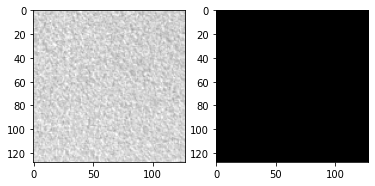

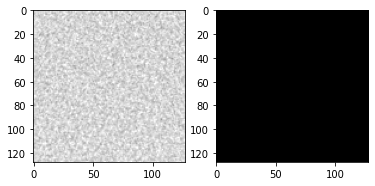

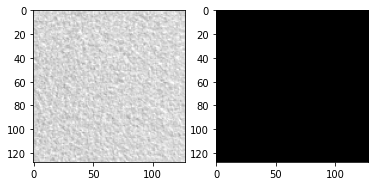

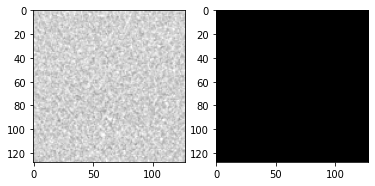

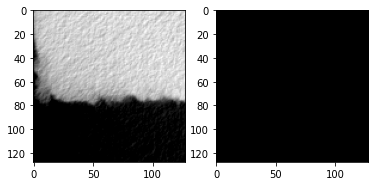

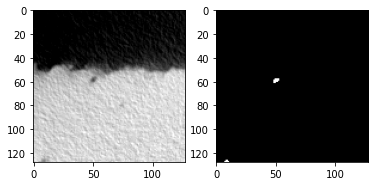

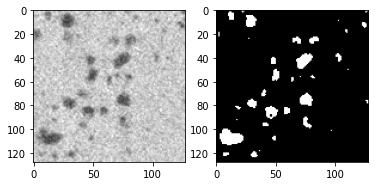

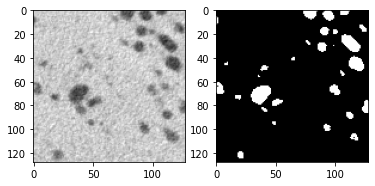

In [25]:
dataloader_train_v2 = DataLoader(dataset=data_train_v2, batch_size=8, shuffle=True, num_workers=2)
iterator = iter(dataloader_train_v2)
imgs, GT = next(iterator)

for im, gt in zip(imgs, GT):
  fig, ax = plt.subplots(nrows = 1, ncols = 2)
  ax[0].imshow(im[0, :, :], cmap='gray', vmin=0, vmax=1)
  ax[1].imshow(gt[0, :, :], cmap='gray', vmin=0, vmax=1)

del imgs, GT

__Question__: Does this seem reasonable now? Are we finally ready for training the model?

# Training (attempt 2)

Let's retrain our model, this time using our newly split dataset, the hyperparameters have been kept the same:

Using device: cuda
epoch 1 / 20, step 32/32, training_loss = 0.4184769, validation_loss = 0.4529438

epoch 2 / 20, step 32/32, training_loss = 0.2930975, validation_loss = 0.3523573

epoch 3 / 20, step 32/32, training_loss = 0.2112030, validation_loss = 0.2931269

epoch 4 / 20, step 32/32, training_loss = 0.1488730, validation_loss = 0.2126341

epoch 5 / 20, step 32/32, training_loss = 0.1152558, validation_loss = 0.1846383

epoch 6 / 20, step 32/32, training_loss = 0.0879007, validation_loss = 0.1440133

epoch 7 / 20, step 32/32, training_loss = 0.0916424, validation_loss = 0.1734119

epoch 8 / 20, step 32/32, training_loss = 0.0626811, validation_loss = 0.1193730

epoch 9 / 20, step 32/32, training_loss = 0.0546696, validation_loss = 0.1077316

epoch 10 / 20, step 32/32, training_loss = 0.0442720, validation_loss = 0.0964158

epoch 11 / 20, step 32/32, training_loss = 0.0485564, validation_loss = 0.1094182

epoch 12 / 20, step 32/32, training_loss = 0.0378379, validation_loss = 0.094

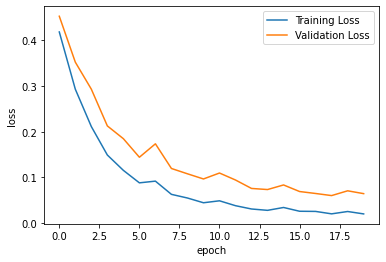

In [26]:
batch_size = 8
learning_rate = 1e-3
n_epochs = 20

model = UNet(feature_maps=16)

t_losses, v_losses = train_model(model, data_train_v2, data_validation_v2, batch_size, learning_rate, n_epochs)

plt.figure()
plt.plot(t_losses, label='Training Loss')
plt.plot(v_losses, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

__Question__: compare this learning curve to the previous learning curve. Is there a difference? Can you explain the difference or lack of difference?


As before, we should next evaluate and inspect the model: We pick a slice from the test set (left), and visualize the result (middle) together with the manual 'correct' output (right):

Text(0.5, 1.0, 'Groundtruth label image')

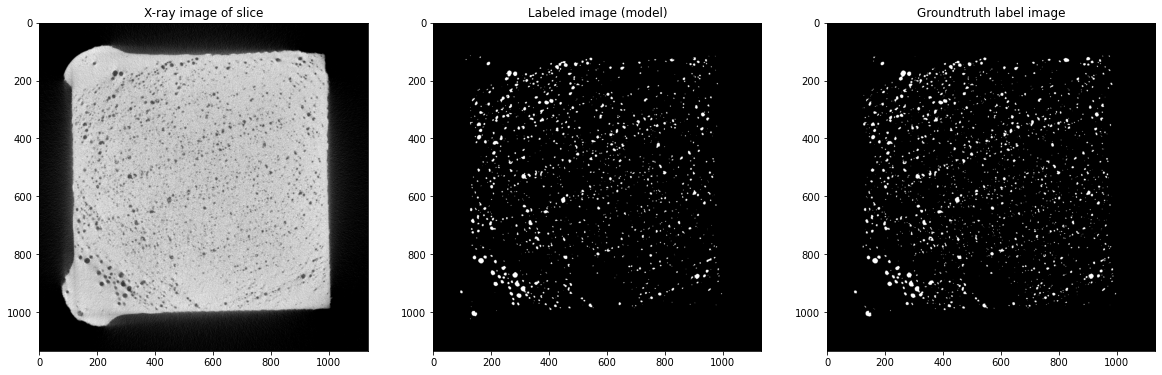

In [27]:
img = data_test_v2.images[data_test_v2.slices[0]]
label_image = segment_slice(model, img, patch_size)
GT = data_test_v2.labels[data_test_v2.slices[0]]

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 20))

ax[0].imshow(img, cmap='gray')
ax[1].imshow(label_image, cmap='gray')
ax[2].imshow(GT, cmap='gray')
ax[0].set_title('X-ray image of slice')
ax[1].set_title('Labeled image (model)')
ax[2].set_title('Groundtruth label image')

__Exercise__: This time it might be interesting to overlay the generated labels from the model and the groundtruth labels. Implement this in code below. (tip: we dit something similar in the previous practical session.)

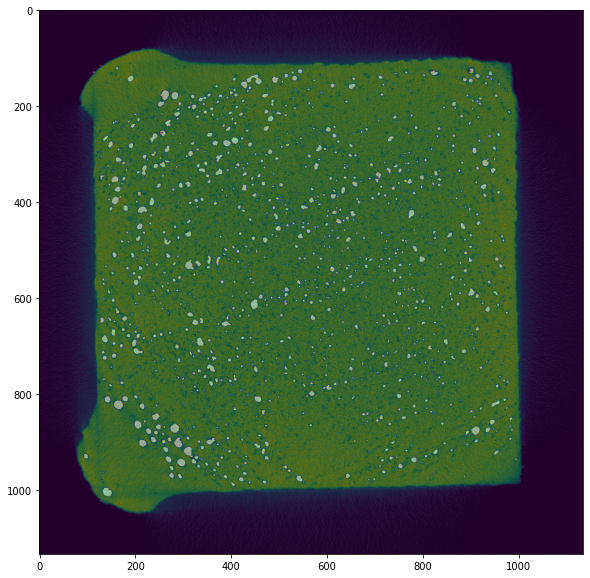

In [28]:
# implement your code here:

plt.figure(figsize=(10,10))

# FILL IN: try different values for alpha (replace None)
plt.imshow(img)
plt.imshow(label_image, cmap='inferno', alpha = 0.5)
plt.show()

Hurray! This time our model did learn to actually segment the pores! But we are far from done. The model is definitely learning something right now, but a important question remains: how good is it actually? 

But let us think about something else first. When we look back at the first training curve we got, it seemed reasonable: both training and validation loss were decreasing per epoch, the losses were low, etc. By looking at both training curves it almost seems that our first model was even better!

__Question__: Why do you think the training loss of our first (bad) model was lower/better than the one for our second (good) model?

<br/><br/>
<br/><br/>

In summary: The learning curve is a valuable tool in interpreting model performance and the learning process. It allows to spot problems and assess the learning procedure during training, and has its uses for model evaluation. However it may still be misleading when used inappropriately. Think critically! 

Luckily we have additional tools at our disposal for model evaluation, two important ones:
  - Qualitative validation, which we've already covered by looking at our model output visually
  - Quantitative validation by computing different (from the loss function) performance metrics on our test set.

Let's get started on the quantitative validation!

# Quantitative Validation

In this part we will evaluate our model quantitively: we will compute a well-chosen evaluation metric over our entire test set. This metric can then be used to interpret how good our model performs and to compare it to other models/methods.

There exist many different evaluation metrics for segmentation. Each one has their use and their best use depends on the use case; The best one depends on what the end users expects the model to do exactly! To be consistent with the first practical sessions we will use the __Intersection Over Union (IOU)__ coefficient also referred to as the Jaccard index.

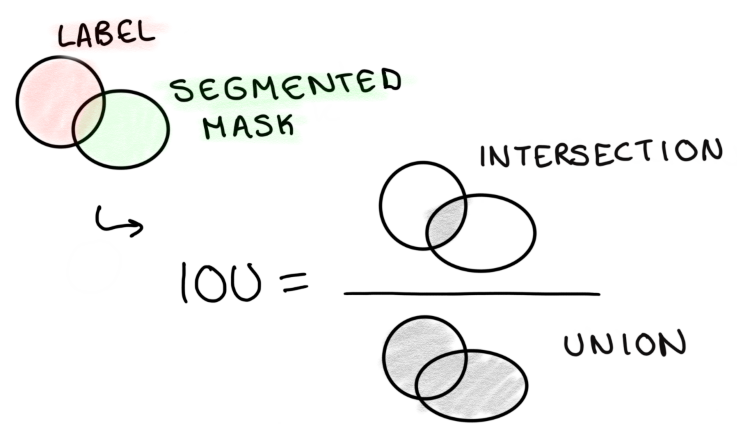

The figure above serves as a reminder to what the Intersection Over Union represents. Can you implement this in a function yourself this time?

__Exercise__: complete the function below that calculates the Intersection Over Union (tip: use logical operators, see:  [documentation](https://numpy.org/doc/stable/reference/routines.logic.html))

In [65]:
# implement your function here 

def IOU(segmentation, groundtruth):
  return (segmentation & groundtruth).sum()/(segmentation ^ groundtruth).sum()

def IOU(masked, labeled):

  intersection = np.logical_and(masked, labeled)

  union = np.logical_or(masked, labeled)

  iou_score = np.sum(intersection) / np.sum(union)

  return iou_score

To test your implementation, we'll try computing the IOU for the image we tested before.

In [66]:
iou = IOU(label_image, GT)
print(f'The IOU score of the output is: {iou}')

The IOU score of the output is: 0.0


__Question__: Is this a good score?

This was just an evaluation over a single test image. For a more conclusive analysis we should compute this over the entire test set.

__Exercise__: implement an evaluation over the entire test set using a for loop in the code below. the *IOU_scores* variable is where we will keep the results. The *slices* variable is the array of slices that we have to go through in our for loop. For every iteration of our for loop the following needs to happen:
  1. get the right image
  2. get its corresponding segmentation output using the *segment_slice* function
  3. get the corresponding groundtruth image
  4. compute the IOU score
  5. add the score to the array of IOU scores 

In [67]:
IOU_scores = []  # we will save the IOU score of every slice in this array
slices = data_test_v2.slices # this array holds the slice numbers that are contained in the test set

# in python, you can add a value to a list like so: IOU_scores.append(value)

# create your for loop here
for i in range(len(slices)):
  img = data_test_v2.images[data_test_v2.slices[i]]
  label_image = segment_slice(model, img, patch_size)
  GT = data_test_v2.labels[data_test_v2.slices[i]]
  IOU_scores.append(IOU(label_image, GT))

Next, we inspect the obtained array of IOU scores. 

__Exercise__: write code below to do the following:

  1. compute the mean, median and standard deviation of the scores (tip: see [documentation](https://numpy.org/doc/stable/reference/routines.statistics.html))
  2. make a bar plot of the scores in function of the slice numbers. (tip: see  [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html), also look at previous code to see an example on how to use matplotlib)

Mean score: 0.4941788730955576, Median score: 0.615840118430792, Standard deviation: 0.2300394229976951


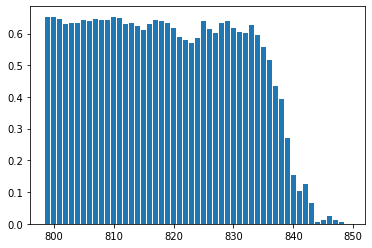

In [74]:
# implement your code here:

#compute the average here:
mean = np.mean(IOU_scores)

#compute the median here:
median = np.median(IOU_scores)

#compute the standard deviation here:
std = np.std(IOU_scores)

print(f'Mean score: {mean}, Median score: {median}, Standard deviation: {std}')

# plot the scores in function of the slice numbers here
_ = plt.bar(slices, IOU_scores)

__Question__: interpret these results. Is the validation consistent for every slice? Or does the performance deviate for some slices?

__Exercise__: analyse one of the slices with deviating performance, in terms of its segmentation output and groundtruth. Write some code to do this below (tip: you can mostly just copy and paste earlier code)

Text(0.5, 1.0, 'Groundtruth label image')

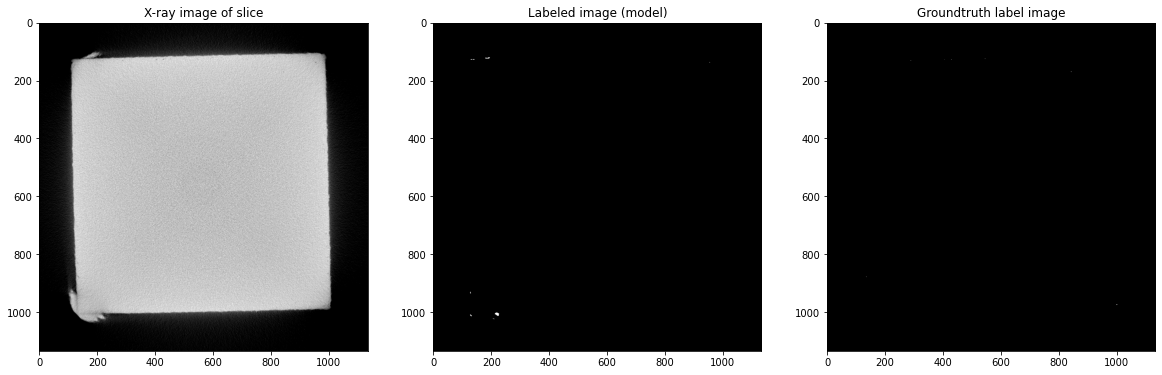

In [75]:
# implement your code here

img = data_test_v2.images[data_test_v2.slices[-1]]
label_image = segment_slice(model, img, patch_size)
GT = data_test_v2.labels[data_test_v2.slices[-1]]

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 20))

ax[0].imshow(img, cmap='gray')
ax[1].imshow(label_image, cmap='gray')
ax[2].imshow(GT, cmap='gray')
ax[0].set_title('X-ray image of slice')
ax[1].set_title('Labeled image (model)')
ax[2].set_title('Groundtruth label image')




__Question__: can you now explain the deviating performance, using your knowledge on the Intersection Over Union score? Does it necessarily mean that the model is bad?

The above shows that no metric is free from bias or free from interpretation errors. Again, be critical!

Following this [link](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics) you can find a list of other metrics related to segmentation.

__Question__: go through this list of metrics and see if you can find a metric that might solve the above problem? Would it be better than IoU overal? State your arguments.

# Comparison with other non-deep learning techniques

Comparing your deep learning techniques to standard non-deep learning techniques is always a good idea. This is usually done to have a baseline comparison or reference loss (as mentioned in the theory lectures). After all, if a deep learning model does not outperform standard techniques, there is little incentive to use it. A deep learning method generally requires more computing power, has less interpretability, is harder to adjust (requires retraining), etc., compared to standard techniques. 

Some examples of non-deep learning techniques were covered in the first practical session. In particular, at some point, a combination of hysteresis thresholding for edge removal and global thresholding was used. At the optimal thresholding value, it reached an IOU score of around 0.78 for some individual slice. This is quite an improvement on what we have from our deep learning model. What could explain this performance gap?

The answer lies in the labeling. If you look at the two patches below and their associated "manual" labeling, two observations can be made:
1. The lighter gray areas of pores are mostly ignored, this is for example very noticable on the pores on the right of the top image. These parts may have a slightly lower intensity due to partial voluming effects, but they are definitely part of a pore.
2. In the bottom image, there is a pore labeled with a small inclusion that is labeled as not pore. Again, due to lower intensity values. This is most likely not human labeling behaviour.

These observations points us towards some evidence that the data was probably not truly "hand-labeled". Instead, some standard techniques were applied, such as global thresholding, with the supervision of a human to determine optimal values. Most likely, this was done on each slice individually. Considering this, the higher score in the first practical session would make sense, as the technique used there (global thresholding), probably approximates very closely the technique that was made to create the labeling in the first place. Especially since the optimal thresholding value was determined for that single slice.

Labeling data using some traditional segmentation technique and subsequently using it to train a deep learning model usually provides little value. The model can only predict as good as the output that it is given, so if the traditional segmentation technique is sub-optimal, so will the deep learning network be after training it on the output of that technique. After all, the deep learning model will learn to approximate that technique. Additionally, if the used segmentation technique for producing the labels is inconsistent across the data, by for example optimising it per slice, it might confuse the model and lead to lower performance. This is because a deep learning network optimizes an average performance over the training data and not an optimal performance for each individual training input (it might, in some cases, but that would be overfitting and generally not good). 

The key takeaway from this discussion is that you should always be aware of how the labeling of your dataset was produced and think about how this might affect the performance of a deep learning model. 

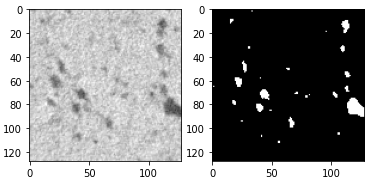

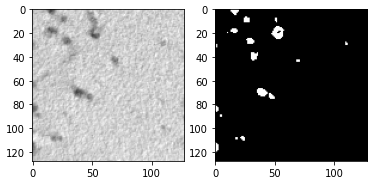

#Impact of label quality



Since supervised neural networks rely on (lots of) training data, we have to wonder what the impact is of this training data quality. Especially in label images there may be a large quality variety: Human annotators make errors, may miss obvious cases, may cheat, may be lazy or tired, may be inconsistent with themselves (intra-annotator) and with other annotators (inter-annotator), etc. To study the effect of label quality, we will perform a small test in this section. We will introduce noise in our training labels to degrade them, then train the neural network again and finally compare the resulting model performance to our previous model.

__Question__: what kind of operation could we apply to the labels to make them more noisy? (tip: there are multiple options, but remember the first practical session)

<br/><br/>
<br/><br/>

In the code below we provide an example for producing the noisy labels in a single slice.

Text(0.5, 1.0, 'Eroded labels')

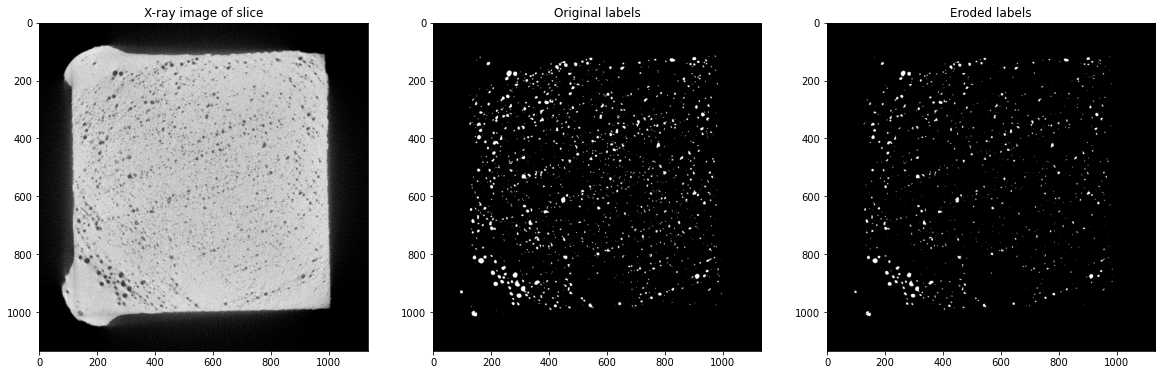

In [76]:
img = images[800]
GT = labels[800]
GT_eroded = morphology.binary_erosion(GT)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 20))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(GT, cmap='gray')
ax[2].imshow(GT_eroded, cmap='gray')
ax[0].set_title('X-ray image of slice')
ax[1].set_title('Original labels')
ax[2].set_title('Eroded labels')

__Exercise__: compute the IoU score of the original label image with the eroded label image to get an idea of how much the label quality has dropped.

In [77]:
# implement your code here:

IOU(GT, GT_eroded)



0.5077939315368707

To train a network on noisy labels we can adjust the data function. This time we will call it *Data_noisy* as seen below. 

__Exercise__: adjust the *Data_noisy* function below to return noisy versions of the image patches.

In [78]:
class Data_noisy(data.Dataset):

  def __init__(self, images:list, labels:list, split:str, patch_size:tuple, max_iter_epoch:int):

    self.images = images
    self.labels = labels
    self.patch_size = patch_size
    self.max_iter_epoch = max_iter_epoch
    
    if(split == 'train'):
      self.slices = np.arange(700, 789)
    elif(split == 'validation'):
      self.slices = np.arange(789, 798)
    elif(split == 'test'):
      self.slices = np.arange(799, 850)
    else: raise Exception(f'A non valid split was given: \'{split}\'. Please specify train, validation or test.')

  def __getitem__(self, i:int):

    # select a random slice from the range of slices
    z = self.slices[np.random.randint(len(self.slices))]

    # get the image and labels
    img = self.images[z]
    GT = self.labels[z]

    
    # select random center positions to extract the patch from
    # we have to be carefull to choose this center such that the patch does not go beyond the boundaries of the image
    x = np.random.randint(self.patch_size[0], img.shape[1]-self.patch_size[0]+1) 
    y = np.random.randint(self.patch_size[1], img.shape[1]-self.patch_size[1]+1) 

    # crop out the patch from the original image and label image
    img = img[x-int(patch_size[0]/2):x+int(patch_size[0]/2), y-int(patch_size[1]/2):y+int(patch_size[1]/2)]
    GT = GT[x-int(patch_size[0]/2):x+int(patch_size[0]/2), y-int(patch_size[1]/2):y+int(patch_size[1]/2)]

    # get both channels for groundtruth (pore/notpore)
    GT = np.array([GT, 1.0-morphology.binary_erosion(GT)])

    # put the data in the correct format for pytorch
    return torch.from_numpy(img).unsqueeze_(0), torch.from_numpy(np.float32(GT))

  def __len__(self):
    return max_iter_epoch

We only want to produce noisy labels for the training data, the validation data will be kept the same.

In [79]:
data_train_noisy = Data_noisy(images, labels, 'train', patch_size, max_iter_epoch)

Finally, we will train this model using the same hyperparameters as before, but this time with the noisy training patches:

Using device: cuda
epoch 1 / 20, step 32/32, training_loss = 0.6106381, validation_loss = 0.6134306

epoch 2 / 20, step 32/32, training_loss = 0.4012653, validation_loss = 0.4243724

epoch 3 / 20, step 32/32, training_loss = 0.2921764, validation_loss = 0.3247480

epoch 4 / 20, step 32/32, training_loss = 0.2162184, validation_loss = 0.2583490

epoch 5 / 20, step 32/32, training_loss = 0.1760268, validation_loss = 0.2208877

epoch 6 / 20, step 32/32, training_loss = 0.1367643, validation_loss = 0.1759275

epoch 7 / 20, step 32/32, training_loss = 0.0918400, validation_loss = 0.1353155

epoch 8 / 20, step 32/32, training_loss = 0.0917635, validation_loss = 0.1336470

epoch 9 / 20, step 32/32, training_loss = 0.0711683, validation_loss = 0.1096544

epoch 10 / 20, step 32/32, training_loss = 0.0617085, validation_loss = 0.1023217

epoch 11 / 20, step 32/32, training_loss = 0.0552642, validation_loss = 0.1030835

epoch 12 / 20, step 32/32, training_loss = 0.0476379, validation_loss = 0.085

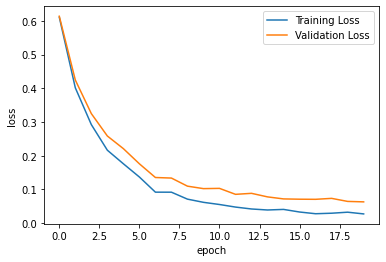

In [80]:
batch_size = 8
learning_rate = 1e-3
n_epochs = 20

model = UNet(feature_maps=16)

t_losses, v_losses = train_model(model, data_train_noisy, data_validation_v2, batch_size, learning_rate, n_epochs)

plt.figure()
plt.plot(t_losses, label='Training Loss')
plt.plot(v_losses, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

__Question__: interpret this learning curve. What can you say about the difference with the previous learning curve (of the normal training data).

__Exercise__: repeat, in code, the same quantitive analysis we have done before. (mean, median, std, plot, etc.)


Mean score: 0.4250907526088244, Median score: 0.5149863760217984, Standard deviation: 0.19975712286892616


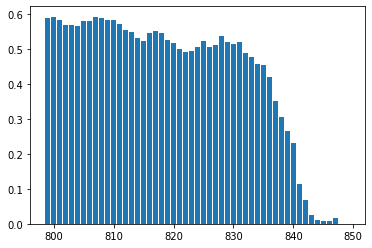

In [82]:
# implement your code here
IOU_scores_noisy = []  # we will save the IOU score of every slice in this array
slices = data_test_v2.slices  # this array holds the slice numbers that are contained in the test set

# create your for loop here

for i in range(len(slices)):
  img = data_test_v2.images[data_test_v2.slices[i]]
  label_image = segment_slice(model, img, patch_size)
  GT = data_test_v2.labels[data_test_v2.slices[i]]
  IOU_scores_noisy.append(IOU(label_image, GT))

# implement your code here:

#compute the average here:
mean = np.mean(IOU_scores_noisy)

#compute the median here:
median = np.median(IOU_scores_noisy)

#compute the standard deviation here:
std = np.std(IOU_scores_noisy)

print(f'Mean score: {mean}, Median score: {median}, Standard deviation: {std}')

# plot the scores in function of the slice numbers here
_ = plt.bar(slices, IOU_scores_noisy)

__Question__: what can you say about the analysis? How does it compare to training with the unaltered labels?

# Other deep learning applications


Neural networks can be used for other applications besides segmentation. Researchers have devised different architectures for different use cases like:

- Computer vision: image classification, object detection, image generation;
- Natural language processing: translation, language generation;
- Speech recognition;
- Robotics;
- Time series analysis;
- ...

Even within use cases related to X-ray CT data, deep learning can perform a variety of tasks:
- Image classification: identify type of image (ex: lung X-ray, chest X-ray), identify specific objects within an image;
- Image registration: aligning multiple X-ray images (or other modalities) to create a composite image;
- Image enhancement: improving visibility of certain features or denoising;
- Anomaly detection: identifying abnormalities without the need of labeled data

It is important to note that many architectures are built in 2D, like the U-Net in this assignment. Nonetheless, their concept may be extended to 3D, often by replacing the 2D by 3D convolutions. That enables learning 3D data features in the same way that 2D filters enable learning features from 2D images. Moving to a full 3D neural network should be well-considered however: moving from 2D to 3D causes a scaling of the number of network parameters (weights) and therefore the required amount of training data. 


#Using this code for your own data

You can use the code written in this notebook and apply it to your own datasets for segmentation. The main things that you will have to change are:
1. the *data* class: in this notebook we loaded the entire dataset into the RAM memory. As mentioned, usually this is not possible. Below is an example given where the images and groundtruth images are read ad hoc. Notice how the input arguments changed to *image_path* and *label_path*, providing a path to the location of the data. Also note the changes to lines 24 and 25 in the code below, it now reads in the images in the *\__getitem\__* function itself. Something similar will have to be coded for your own datasets.

2. The network output. In this notebook we worked on a binary classification problem. The U-net output thus only had two output channels. This correct output was easy to construct, as one channel was just the inverse of the other. You can see how this was done on line 37 of the code below. If working with more than two classes, two things need to be changed:
  1. The U-net model must be defined that way, it needs to be defined with more output channels. Luckily, by the way the model was programmed, this is an easy fix. The U-net as coded in this notebook has an input argument, *out_channels*, that does just that. So you would define the model in code as: *model = UNet(feature_maps=..., out_channels=...)*
  2. The output needs to be in the correct shape for the model (split up into the different channels). This might be annoying, since you will typically have labeled images where each pixel has a value corresponding to its label. This is a single channel image. We need some code to split this up into different channels. Some example code is provided below.

In [83]:
 class Data_custom_example(data.Dataset):

  def __init__(self, image_path:str, label_path:str, split:str, patch_size:tuple, max_iter_epoch:int):

    self.image_path = image_path
    self.label_path = label_path
    self.patch_size = patch_size
    self.max_iter_epoch = max_iter_epoch
    
    if(split == 'train'):
      self.slices = np.arange(700, 789)
    elif(split == 'validation'):
      self.slices = np.arange(789, 798)
    elif(split == 'test'):
      self.slices = np.arange(799, 850)
    else: raise Exception(f'A non valid split was given: \'{split}\'. Please specify train, validation or test.')

  def __getitem__(self, i:int):

    # select a random number from the range of images
    z = self.slices[np.random.randint(len(self.slices))]

    # read in the image and labels
    img = io.imread(os.path.join(self.image_path, f'slice_{z}.tif'))
    GT = io.imread(self.label_path, img_num=z).astype(bool)
    
    # select random center positions to extract the patch from
    # we have to be carefull to choose this center such that the patch does not go beyond the boundaries of the image
    x = np.random.randint(self.patch_size[0], img.shape[1]-self.patch_size[0]+1) 
    y = np.random.randint(self.patch_size[1], img.shape[1]-self.patch_size[1]+1) 

    # crop out the patch from the original image and label image
    img = img[x-int(patch_size[0]/2):x+int(patch_size[0]/2), y-int(patch_size[1]/2):y+int(patch_size[1]/2)]
    GT = GT[x-int(patch_size[0]/2):x+int(patch_size[0]/2), y-int(patch_size[1]/2):y+int(patch_size[1]/2)]

    # get both channels for groundtruth (pore/notpore)
    GT = np.array([GT, 1.0-GT])

    # put the data in the correct format for pytorch
    return torch.from_numpy(img).unsqueeze_(0), torch.from_numpy(np.float32(GT))

  def __len__(self):
    return max_iter_epoch

**Splitting up a labeled image into different binary channels**

To illustrate this, we'll create an example numpy array with three classes. The image contains mostly class 0, with a small square in the top left of class 1 and a larger square of class 2 in the bottom right, as seen below:

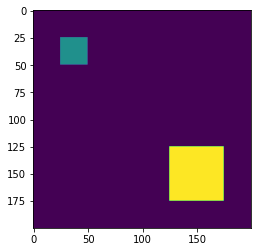

In [84]:
example_labeled_image = np.zeros((200, 200))
example_labeled_image[25:50, 25:50] = 1
example_labeled_image[125:175, 125:175] = 2

plt.imshow(example_labeled_image)

The following code creates three variables, channel1, channel2, and channel3, which are assigned the result of a comparison operation. The comparison operation used is the "==" operator, which checks if the value on the left side of the operator is equal to the value on the right side.

channel1, channel2 and channel3 are now matrices of boolean values, where each element of the array/matrix is True if the corresponding element in example_labeled_image is equal to the value on the right side of the operator, otherwise the value is False. Essentially, we are making binary masks for each class.

Text(0.5, 1.0, 'Channel 3: class 2')

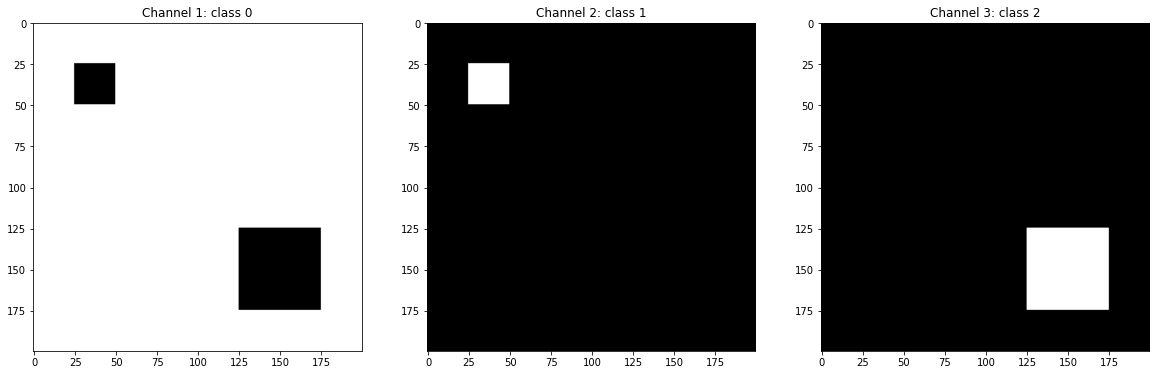

In [85]:
channel1 = example_labeled_image == 0
channel2 = example_labeled_image == 1
channel3 = example_labeled_image == 2

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 20))
ax[0].imshow(channel1, cmap='gray')
ax[1].imshow(channel2, cmap='gray')
ax[2].imshow(channel3, cmap='gray')
ax[0].set_title('Channel 1: class 0')
ax[1].set_title('Channel 2: class 1')
ax[2].set_title('Channel 3: class 2')

Now these channels can be stacked together into a single numpy array, creating our desired output, which can be interpreted by the U-net model.

In [86]:
out = np.array([channel1, channel2, channel3])

In our earlier data class, this kind of code would replace line 37.

# Hyperparameter tuning

For the remainder of the time, try tuning the hyperparameters of the model to achieve better results. The previous model was not optimized, some standard values were chosen for the hyperparameters, but no time was spent to check if this provided us with the best results. Maybe there are some better values for the hyperparameters?

You can adjust the: learning rate, batch size, number of epochs, patch size, number of feature maps, number of samples in a epoch. Thinking of a better way to split the training and validation data? Perhaps you want to try another loss function? Anything goes in this last part.

But before we jump into that. It might be convenient to create a single function that computes our earlier quantitative measurements given some model. That way, each time you try a new model, only a single function call is needed to evaluate the model. 

__Exercise__: implement a function (*evaluate_model*) that evaluates a model. It should have three inputs: a model, the slice numbers to be tested and the patch_size. The function should do the following: compute the IoU score for each of the slices; compute the mean, median and standard deviation and print out the values; plot a bar plot of the IoU scores in function of the slice numbers.

In [89]:
def evaluate_model(ml_model, slice_range, patch_size):
  IOU_scores = []  # we will save the IOU score of every slice in this array

  for i in range(len(slice_range)):
    img = data_test_v2.images[slice_range[i]]
    label_image = segment_slice(ml_model, img, patch_size)
    GT = data_test_v2.labels[slice_range[i]]
    IOU_scores.append(IOU(label_image, GT))

  # implement your code here:

  #compute the average here:
  mean = np.mean(IOU_scores)

  #compute the median here:
  median = np.median(IOU_scores)

  #compute the standard deviation here:
  std = np.std(IOU_scores)

  print(f'Mean score: {mean}, Median score: {median}, Standard deviation: {std}')

  # plot the scores in function of the slice numbers here
  _ = plt.bar(slice_range, IOU_scores)


For this last part, we will focus on just 20 slices of the test set, to speed up the evaluation. If the last exercise is implemented correctly, the following code should run:

Mean score: 0.5665420491943677, Median score: 0.5688683328544593, Standard deviation: 0.020127283628583535


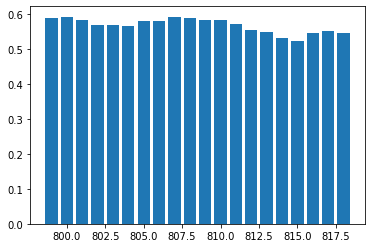

In [90]:
test_slices = data_test_v2.slices[0:20]
evaluate_model(model, test_slices, patch_size)

You are now ready to experiment with different hyperparameters. The rest is up to you:

In [ ]:
# TODO: find more optimal hyperparameters






